# Exploring Mental Health Data
**Objective:** Predict whether an individual suffers from depression based on a set of responses from a mental health survey.

**Problem task:** Binary classification on the target variable depression (0 = false, 1 = true)

**Dataset source:** Kaggle - Playground Series S4E11


In [2]:
#Marta path:
#Ricardo path:
#Sara path: "/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/train.csv"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
train_data = pd.read_csv("/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/train.csv")
test_data = pd.read_csv("/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/test.csv")

print(train_data.head())
train_data.describe()

   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours     

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [3]:
#duplicate removal
bf = len(train_data)
print(f"Number of rows before removing duplicates: {len(train_data)}")
train_data = train_data.drop_duplicates()
af = len(train_data)
print(f"Number of rows after removing duplicates: {len(train_data)}")
if (bf-af) == 0:
    print("(No dup data found)")

Number of rows before removing duplicates: 140700
Number of rows after removing duplicates: 140700
(No dup data found)


In [4]:
#missing value check
def missing_value_info(df):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    return pd.DataFrame({'Missing Values': total, 'Percent Missing': percent}).sort_values(by='Percent Missing', ascending=False)
missing_info_with_0 = missing_value_info(train_data)
missing_info = missing_info_with_0[missing_info_with_0['Percent Missing'] > 0.0]
print(missing_info)
print(missing_info_with_0)


                    Missing Values  Percent Missing
Study Satisfaction          112803        80.172708
Academic Pressure           112803        80.172708
CGPA                        112802        80.171997
Profession                   36630        26.034115
Work Pressure                27918        19.842217
Job Satisfaction             27910        19.836532
Dietary Habits                   4         0.002843
Financial Stress                 4         0.002843
Degree                           2         0.001421
                                       Missing Values  Percent Missing
Study Satisfaction                             112803        80.172708
Academic Pressure                              112803        80.172708
CGPA                                           112802        80.171997
Profession                                      36630        26.034115
Work Pressure                                   27918        19.842217
Job Satisfaction                                27910 

since these columns were spotted for missing values, we want to understand their appearance: how many are missing (NaN count in value_counts), if there unexpected 0s or negative values.

### Data prepp

In [5]:
#train_data['Study Satisfaction'].value_counts(dropna=False)
#train_data['Academic Pressure'].value_counts(dropna=False)
#train_data['CGPA'].value_counts(dropna=False)
#train_data['Profession'].value_counts(dropna=False)
#train_data['Work Pressure'].value_counts(dropna=False)
#train_data['Job Satisfaction'].value_counts(dropna=False)
#train_data['Dietary Habits'].value_counts(dropna=False)
#train_data['Financial Stress'].value_counts(dropna=False)
pd.set_option('display.max_rows', None)
train_data['Degree'].value_counts(dropna=False)
#regulated
#Comclusion: all our missing vals are NANS

Degree
Class 12                14729
B.Ed                    11691
B.Arch                   8742
B.Com                    8113
B.Pharm                  5856
BCA                      5739
M.Ed                     5668
MCA                      5234
BBA                      5030
BSc                      5027
MSc                      4879
LLM                      4647
M.Pharm                  4537
M.Tech                   4475
B.Tech                   4425
LLB                      4348
BHM                      4305
MBA                      3818
BA                       3750
ME                       3632
MD                       3383
MHM                      3286
BE                       3104
PhD                      3103
M.Com                    3094
MBBS                     3082
MA                       2887
M.Arch                      5
UX/UI Designer              4
B.Sc                        3
Kalyan                      3
M                           3
LLBA                        2
NaN

In [6]:
# Forçar a visualização completa das contagens
pd.set_option('display.max_rows', None)  # Isso vai permitir que todos os valores sejam exibidos
print(train_data['Profession'].value_counts(dropna=False))


Profession
NaN                       36630
Teacher                   24906
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Accountant                 13

In [7]:
train_data['Profession'].value_counts(dropna=False)

valid_professions = [
    "Teacher", "Content Writer", "Architect", "Consultant", "HR Manager",
    "Pharmacist", "Doctor", "Business Analyst", "Entrepreneur", "Chemist",
    "Chef", "Educational Consultant", "Data Scientist", "Researcher", "Lawyer",
    "Customer Support", "Marketing Manager", "Pilot", "Travel Consultant",
    "Plumber", "Sales Executive", "Manager", "Judge", "Electrician",
    "Financial Analyst", "Software Engineer", "Civil Engineer", "UX/UI Designer",
    "Digital Marketer", "Accountant", "Mechanical Engineer", "Graphic Designer",
    "Research Analyst", "Investment Banker", "Analyst", "Academic", "Unemployed", "Medical Doctor", "City Manager", "Family Consultant"
]

# corrigir erros digitação
def correct_profession(value):
    corrections = {
        "Finanancial Analyst": "Financial Analyst",
        # Adicionar mais ??
    }
    return corrections.get(value, value)

train_data['Profession'] = train_data['Profession'].apply(correct_profession)

test_data['Profession'] = test_data['Profession'].apply(correct_profession)

def clean_profession(value):
    if pd.isna(value):
        return value  # mantém NaN
    return value if value in valid_professions else "other"

train_data['Profession'] = train_data['Profession'].apply(clean_profession)
test_data['Profession'] = test_data['Profession'].apply(clean_profession)

train_data['Profession'].value_counts(dropna=False)

test_data['Profession'].value_counts(dropna=False)

# these are names: ["Yogesh", "Pranav", "Dev", "Yuvraj"]
# these seem to be localities ["Patna", "Visakhapatnam", "Nagpur", "FamilyVirar"]
# and these ? what are hey ? not jobs. ["Patna", "Visakhapatnam", "Nagpur", "FamilyVirar"]
#degrees like MBA
#substringing

Profession
NaN                       24632
Teacher                   16385
Content Writer             5187
Architect                  2982
Consultant                 2920
Pharmacist                 2656
HR Manager                 2601
Doctor                     2198
Business Analyst           2186
Chemist                    1967
Financial Analyst          1942
Entrepreneur               1935
Chef                       1844
Educational Consultant     1827
Data Scientist             1582
Lawyer                     1497
Researcher                 1496
Pilot                      1448
Customer Support           1422
Marketing Manager          1284
Judge                      1189
Travel Consultant          1188
Manager                    1155
Sales Executive            1139
Plumber                    1123
Electrician                1121
Software Engineer          1002
Digital Marketer            942
Civil Engineer              938
UX/UI Designer              915
Accountant                  8

In [8]:
import re
# handle ranges like 6-8, handle more than/less than X,handle direct numeric values
print(len(train_data['Sleep Duration']))
#15 rows lost
def normalize_sleep_duration(column):
    def normalize(value):
        value = str(value).strip()

        match_range = re.match(r"(\d+)\s*-\s*(\d+)", value)
        if match_range:
            x, y = map(int, match_range.groups())
            return (x + y) / 2

        match_more = re.match(r"More than (\d+)", value, re.IGNORECASE)
        if match_more:
            return int(match_more.group(1)) + 0.5

        match_less = re.match(r"Less than (\d+)", value, re.IGNORECASE)
        if match_less:
            return int(match_less.group(1)) - 0.5

        try:
            return float(value)
        except ValueError:
            return pd.NA 

    return column.apply(normalize)

def normalize_large_sleep_values(column):
    def adjust_large(value):
        try:
            if pd.notna(value) and value >= 12:
                return round(value / 7 * 2) / 2
            return value
        except:
            return pd.NA
    return column.apply(adjust_large)

train_data['Sleep Duration'] = normalize_sleep_duration(train_data['Sleep Duration'])
train_data['Sleep Duration'] = normalize_large_sleep_values(train_data['Sleep Duration'])
test_data['Sleep Duration'] = normalize_sleep_duration(test_data['Sleep Duration'])
test_data['Sleep Duration'] = normalize_large_sleep_values(test_data['Sleep Duration'])

print(train_data['Sleep Duration'].value_counts())

140700
Sleep Duration
4.5     38792
7.5     36970
8.5     32729
5.5     32142
3.5        16
6.5        11
7.0         6
5.0         6
2.5         5
10.5        2
10.0        2
1.5         1
6.0         1
2.0         1
8.0         1
Name: count, dtype: int64


In [9]:
valid_dietary = ["Moderate", "Unhealthy", "Healthy"]

train_data["Dietary Habits"] = train_data["Dietary Habits"].apply(
    lambda x: x if pd.isna(x) or x in valid_dietary else "other"
)
test_data["Dietary Habits"] = test_data["Dietary Habits"].apply(
    lambda x: x if pd.isna(x) or x in valid_dietary else "other"
)


print(train_data['Dietary Habits'].value_counts(dropna = False))

Dietary Habits
Moderate     49705
Unhealthy    46227
Healthy      44741
other           23
NaN              4
Name: count, dtype: int64


In [10]:
def normalize_degree(column):
    def clean(item):
        if isinstance(item, str):
            item = item.replace('.', '').replace(' ', '')
            return item
        else:
            return 'invalid'
    
    column = column.apply(clean)
    def remove_names(item):
            if (len(item) > 1 and item[0].isupper() and item[1].isupper() and item[0] in ['L', 'P', 'B', 'M']) or item == 'Class12' or item == "PhD":
                return item
            else:
                return 'invalid' 
    return column.apply(remove_names)
#importante dar NA aos inválidos para dar drop
train_data['Degree'] = normalize_degree(train_data['Degree'])
test_data['Degree'] = normalize_degree(test_data['Degree'])

degree_counts = train_data['Degree'].value_counts()
rare_degrees = degree_counts[degree_counts <= 5].index

train_data['Degree'] = train_data['Degree'].apply(lambda x: 'other' if x in rare_degrees else x)
test_data['Degree'] = test_data['Degree'].apply(lambda x: 'other' if x in rare_degrees else x)
     

print(train_data['Degree'].value_counts(dropna = False))

Degree
Class12    14729
BEd        11693
BArch       8744
BCom        8113
BPharm      5858
BCA         5739
MEd         5670
MCA         5234
BBA         5031
BSc         5030
MSc         4879
LLM         4647
MPharm      4538
MTech       4476
BTech       4425
LLB         4348
BHM         4305
MBA         3818
BA          3750
ME          3632
MD          3383
MHM         3286
BE          3104
PhD         3103
MCom        3094
MBBS        3082
MA          2887
invalid       72
other         30
Name: count, dtype: int64


In [ ]:
print(train_data['Work/Study Hours'].value_counts(dropna=False))
"""
train_data['Work/Study Hours'].value_counts(dropna=False)
train_data['Academic Pressure'].value_counts(dropna=False)
train_data['CGPA'].value_counts(dropna=False)
train_data['Profession'].value_counts(dropna=False)
train_data['Work Pressure'].value_counts(dropna=False)
train_data['Job Satisfaction'].value_counts(dropna=False)
train_data['Dietary Habits'].value_counts(dropna=False)
train_data['Financial Stress'].value_counts(dropna=False)
train_data['Degree'].value_counts(dropna=False)"""



Our decision tree classifier requires binary values. Thus, let's convert bicategorical variables in to 0/1.

In [11]:

# Gender column: Male -> 1, Female -> 0
train_data['Gender'] = train_data['Gender'].replace({'Male': 1, 'Female': 0})

# Working Professional or Student column: Working Professional -> 1, Student -> 0
train_data['Working Professional or Student'] = train_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})

# Have you ever had suicidal thoughts?
train_data['Have you ever had suicidal thoughts ?'] = train_data['Have you ever had suicidal thoughts ?'].replace({'Yes': 1, 'No': 0})

train_data['Family History of Mental Illness'] = train_data['Family History of Mental Illness'].replace({'Yes': 1, 'No': 0})

test_data['Gender'] = test_data['Gender'].replace({'Male': 1, 'Female': 0})

test_data['Working Professional or Student'] = test_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})

test_data['Have you ever had suicidal thoughts ?'] = test_data['Have you ever had suicidal thoughts ?'].replace({'Yes': 1, 'No': 0})

test_data['Family History of Mental Illness'] = test_data['Family History of Mental Illness'].replace({'Yes': 1, 'No': 0})

/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykernel_35123/736765039.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Gender'] = train_data['Gender'].replace({'Male': 1, 'Female': 0})
/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykernel_35123/736765039.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Working Professional or Student'] = train_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})
/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykernel_

## Merging Columns

we can detect in our data two categories of individuals, identifiable by their attributes:
- **Students:** academic pressure, CGPA, study satisfaction, degree
- **Worker Professionals:** work pressure, profession, job satisfaction

So we decided to merge the columns that mean the same thing relatively yo each of these categories.

For example: 'Job Satisfaction' and 'Study Satisfaction' merge into just 'Satisfaction'

In [12]:
train_data['Satisfaction'] = train_data[['Job Satisfaction', 'Study Satisfaction']].mean(axis=1, skipna=True)

train_data = train_data.drop(columns=['Job Satisfaction', 'Study Satisfaction'])
train_data['Pressure'] = train_data[['Work Pressure', 'Academic Pressure']].mean(axis=1, skipna=True)

train_data = train_data.drop(columns=['Work Pressure', 'Academic Pressure'])
print(train_data[['Pressure']].head())

print(train_data[['Satisfaction']].head())

train_data.loc[
    train_data['Profession'].isna() & (train_data['Working Professional or Student'] == 0),
    'Profession'
] = 'Student'

train_data.loc[
    train_data['Profession'].isna() & (train_data['Working Professional or Student'] != 0),
    'Profession'
] = 'other'
train_data = train_data.drop(columns=['CGPA'])
print(train_data[['Profession']].head())

test_data['Satisfaction'] = test_data[['Job Satisfaction', 'Study Satisfaction']].mean(axis=1, skipna=True)

test_data = test_data.drop(columns=['Job Satisfaction', 'Study Satisfaction'])
test_data['Pressure'] = test_data[['Work Pressure', 'Academic Pressure']].mean(axis=1, skipna=True)

test_data = test_data.drop(columns=['Work Pressure', 'Academic Pressure'])


test_data.loc[
    test_data['Profession'].isna() & (test_data['Working Professional or Student'] == 0),
    'Profession'
] = 'Student'

test_data.loc[
    test_data['Profession'].isna() & (test_data['Working Professional or Student'] != 0),
    'Profession'
] = 'other'
test_data = test_data.drop(columns=['CGPA'])


   Pressure
0       5.0
1       4.0
2       5.0
3       5.0
4       1.0
   Satisfaction
0           2.0
1           3.0
2           2.0
3           1.0
4           1.0
         Profession
0              Chef
1           Teacher
2           Student
3           Teacher
4  Business Analyst


In [13]:
train_data.to_csv("train_merge.csv", index=False)
test_data.to_csv("test_merge.csv", index=False)

##  Undersampling with priority

In [14]:
#UNDERSAMPLING COM PRIORIDADE

from sklearn.utils import resample
import pandas as pd

X = train_data.drop("Depression", axis=1)
y = train_data["Depression"]

data = pd.concat([X, y], axis=1)

class_counts = data["Depression"].value_counts()
min_class_size = class_counts.min()

priority_cols = ["Profession", "Degree", "Dietary Habits"]

balanced_data = []

for label in class_counts.index:
    subset = data[data["Depression"] == label]

    if len(subset) > min_class_size:
        
        to_keep = min_class_size
        
        # Primeira prioridade: linhas com Nan
        na_rows = subset[priority_cols].isna().any(axis=1)
        subset = subset[~na_rows]

        # Segunda prioridade: linhas com "invalid"
        invalid_rows = subset[subset[priority_cols].isin(["invalid"]).any(axis=1)]
        subset = subset.drop(invalid_rows.index)

        # Terceira prioridade: linhas com "other"
        other_rows = subset[subset[priority_cols].isin(["other"]).any(axis=1)]
        subset = subset.drop(other_rows.index)

        remaining_needed = to_keep


        if len(subset) >= remaining_needed:
            to_sample = subset.sample(remaining_needed, random_state=42)
        else:
            # Remover todos os 'priority' e sortear os restantes
            rows_needed = remaining_needed - len(subset)

            if len(other_rows) >= rows_needed:
                to_sample = pd.concat([subset, other_rows.sample(rows_needed, random_state=42)])
            else:
                still_needed = rows_needed - len(other_rows)
                to_sample = pd.concat([
                    subset,
                    other_rows,
                    invalid_rows.sample(still_needed, random_state=42)
                ])
    else:

        to_sample = subset

    balanced_data.append(to_sample)

undersampled_data = pd.concat(balanced_data)

undersampled_data.to_csv("final_train_dataset.csv", index=False)


In [15]:
train_data = undersampled_data.copy()

Após o undersampling por forma a normalizar a razão No depression/Depression nos dados de teste, o número de casos ficou:

No depression: 5084

Depression: 5143

In [16]:
import pandas as pd
df = pd.read_csv("final_train_dataset.csv")
print(df.columns)
print(df.head())


Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Satisfaction', 'Pressure',
       'Depression'],
      dtype='object')
       id     Name  Gender   Age      City  Working Professional or Student  \
0  137338   Simran       0  22.0     Patna                                1   
1   28857    Aryan       1  32.0     Patna                                0   
2   70323      Ira       0  60.0  Varanasi                                1   
3  105197   Raghav       1  38.0  Vadodara                                1   
4    2102  Krishna       1  41.0    Mumbai                                1   

          Profession  Sleep Duration Dietary Habits Degree  \
0  Marketing Manager             5.5       Moderate   BCom   
1            Student             8.5       

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np

data = df.copy()
data_test = test_data.copy()

categorical_cols_train = data.select_dtypes(include=['object']).columns


# transforma as colunas com "palavras" em numeros
label_encoders = {}
for col in categorical_cols_train:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

for col in categorical_cols_train:
    if col in data_test.columns:
        le = label_encoders[col]
        data_test[col] = data_test[col].apply(lambda x: x if x in le.classes_ else 'unknown')

        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')

        data_test[col] = le.transform(data_test[col].astype(str))


X_train = data.drop(columns='Depression')
y_train = data['Depression']

X_test = data_test[X_train.columns]


# Tratar valores nulos (usar média quando tem valores nulos)
imputer = SimpleImputer(strategy='mean')
train_data_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)



#DUVIDA do que fazer aqui
#apaga as linhas do teste com coluna nao numericas
#mask = X_test.applymap(lambda x: isinstance(x, (int, float, np.number))).all(axis=1)
#X_test_numeric = X_test[mask]

#ALTERNATIVA:
# Converter todas as colunas para numérico
X_test = X_test.apply(pd.to_numeric, errors='coerce')

test_data_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


drop_cols = ['id', 'Name', 'City']
train_data_clean = train_data_imputed.drop(columns=drop_cols, errors='ignore')
test_data_clean = test_data_imputed.drop(columns=drop_cols, errors='ignore')

# Dividir em treino e teste
X_trainSplit, X_testSplit, y_trainSplit, y_testSplit = train_test_split(train_data_clean, y_train, test_size=0.2, random_state=42)



## Plotting

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.scatterplot(x='Work/Study Hours', y='Sleep Duration',
                hue='Have you ever had suicidal thoughts ?', data=train_data_clean)
plt.title('Work Hours vs. Sleep Duration')
plt.show()

In [ ]:
sb.pairplot(train_data_clean[[
    'Satisfaction', 'Sleep Duration', 'Work/Study Hours',
    'Have you ever had suicidal thoughts ?'
]], hue='Have you ever had suicidal thoughts ?')
plt.show()

## Algorithms

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time


start_time = time.time()

# I have tried other kernels (linear, poly and sigmoid) and they all perform similarly, the sigmoid being the worst
model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale', probability=False))
model.fit(X_trainSplit, y_trainSplit)

end_time = time.time()
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds") #when probability is true (to collect data), it takes ~5 times longer to train

y_pred = model.predict(X_testSplit)
conf_matrix = confusion_matrix(y_testSplit, y_pred)

vector_accuracy = accuracy_score(y_testSplit, y_pred)

print("Accuracy:", accuracy_score(y_testSplit, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()

# ROC curve
y_pred_proba = model.predict_proba(X_testSplit)[:, 1]
fpr, tpr, thresholds = roc_curve(y_testSplit, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc='lower right')
plt.grid()
plt.show()


print("\nClassification Report:\n", classification_report(y_testSplit, y_pred))



#### K-NEIGHBOUR

Para este algortimo é necessário que os dados estejam padronizados para que nenhuma variável influencie desproporcionalmente o cálculo da distância. Isso melhora a performance e a precisão do modelo.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Padronizar os dados (por tudo na mesma escala : nao pode idade(0-100) e genero(0 ou 1), é preciso escalar)

#Este é com o split para fazermos as métricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainSplit)
X_test_scaled = scaler.transform(X_testSplit)


# Este é para os dados de teste real que queremos tentar prever
scaler = StandardScaler()
X_train_scaled_real = scaler.fit_transform(train_data_imputed)
X_test_scaled_real = scaler.transform(test_data_imputed)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

start_time = time.time()
# Instanciar e treinar o modelo
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_scaled, y_trainSplit)

end_time = time.time()
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds") #when probability is true (to collect data), it takes ~5 times longer to train

# Fazer previsões
y_pred = knn.predict(X_test_scaled)

# Avaliar o desempenho
accuracy_before = accuracy_score(y_testSplit, y_pred)
conf_matrix = confusion_matrix(y_testSplit, y_pred)
class_report = classification_report(y_testSplit, y_pred)

class_report

Através da análise dos resultados obtidos concluímos que os valores de precision,  recall e F1-score indicam que o modelo tem boa capacidade de prever corretamente se o indivíduo tem ou não depressão, não havendo muitos falsos positivos nem falsos negativos e que não favorece uma mais classe mais do que a outra. Além disso, as médias macro e ponderada das métricas também ficaram em 91%, o que reforça o equilíbrio do desempenho do modelo.


##### Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()

##### KNN Hyperparameter

De modo a tentar maximizar o desempenho do nosso modelo é preciso fazer uma escolha adequada dos hyperparameters, tal como o número de neighbours, o tipo de ponderação (weight ou uniform) e a métrica utilizada para calcular a distância. Para encontrar a melhor combinação desses hyperparameters, podemos aplicada a técnica de validação cruzada com busca em grid (Grid Search).
Para a validação cruzada usamos 10 divisões estratificadas (StratifiedKFold), o que garante que a proporção entre as classes se mantém em cada partição de treino e validação. Este processo permite avaliar de forma mais robusta o desempenho do modelo e selecionar os parâmetros que oferecem os melhores resultados.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv)

grid_search.fit(X_train_scaled, y_trainSplit)

# Melhor modelo
best_knn = grid_search.best_estimator_

print("Melhores parâmetros encontrados:", grid_search.best_params_)
print("Melhor score de validação cruzada:", grid_search.best_score_)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Previsão com o melhor modelo
y_pred_best = best_knn.predict(X_test_scaled)

# Avaliação
knn_accuracy = accuracy_score(y_testSplit, y_pred_best)
conf_matrix_best = confusion_matrix(y_testSplit, y_pred_best)
class_report = classification_report(y_testSplit, y_pred_best)

print("Accuracy:", knn_accuracy)
print("Classification Report:\n", class_report)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()

##### Comparison

In [ ]:
import matplotlib.pyplot as plt

labels = ['Before Tuning', 'After Tuning']
scores = [accuracy_before, knn_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison - KNN')
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

Através do gráfico é possível concluir que a melhoria na accuracy do modelo após realizar hyperparameter tunning foi mínima(0,91 para 0,92). Isto pode ser explicado por o modelo já estar bem ajustado inicialmente, ou porque o conjunto de dados não exigia ajustes complexos. Apesar do pequeno aumento da accuracy, o tuning contribuiu para validar a robustez do modelo.

##### graphics / confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()

y_prob = best_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_testSplit, y_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A confusion matrix e o gráfico da ROC curve vêm a reforçar aquilo que as metricas nos permitiram concluir. A confusion matrix permite-nos concluir o seguinte:

- Verdadeiros Positivos (TP): 4639 – Casos corretamente classificados como com depressão.

- Verdadeiros Negativos (TN): 4705 – Casos corretamente classificados como sem depressão.

- Falsos Positivos (FP): 379 – Casos sem depressão classificados erroneamente como com depressão.

- Falsos Negativos (FN): 504 – Casos com depressão classificados erroneamente como sem depressão.

Esses valores mostram que o modelo está bom tanto para identificar corretamente quem tem depressão quanto quem não tem. A maioria dos casos foi classificada corretamente.

A ROC curve mostra a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos. A Área sob a Curva (AUC) é 0.96, o que indica excelente capacidade discriminativa do modelo — ou seja, ele consegue distinguir muito bem entre as classes com e sem depressão.

##### Learning curve

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define o número de divisões de treino/teste
cv = StratifiedKFold(n_splits=5)

# Gera os valores de treino e validação para diferentes tamanhos de treino
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_scaled, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=1
)

# Calcula média e desvio padrão
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title('Learning Curve - KNN')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

O modelo está a obter valores maiores de _accuracy_ com mais dados, tanto em treino quanto em validação.

Existe uma pequena diferença (~2%) entre treino e validação, o que é normal para KNN e indica leve overfitting.

As curvas não estão a convergir totalmente o que pode indicar que o modelo ainda não atingiu o seu limite de aprendizagem e que talvez, com mais dados ou com ajustes no modelo (tal como o valor de k), o desempenho da validação possa melhorar ainda mais.

#### KNN Accuracy para diferentes valores de k

In [ ]:
import numpy as np

# Testar vários valores de k (1 a 20)
k_values = range(1, 11)
accuracies = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_scaled, y_trainSplit)
    y_pred_k = knn_k.predict(X_test_scaled)
    acc = accuracy_score(y_testSplit, y_pred_k)
    accuracies.append(acc)

# Plot da acurácia vs. número de vizinhos (k)
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

Através da análise do gráfico, podemos concluir que para valores de k muito baixos (como 1 ou 2), a acurácia também é mais reduzida. Isso pode ser explicado pelo fato de o modelo estar muito sensível ao overfitting, ajustando-se demais aos dados de treino.
A partir de k=3 o valor de accuracy aumenta significativamente e estabiliza a partir de k=5 , o que nos levou a utilizar este valor de k no nosso modelo. Contudo, o melhor desempenho está entre k = 9 e k = 10, com acurácia próxima de 0.917.

O modelo KNN melhora seu desempenho conforme k aumenta até cerca de 9 ou 10, o que indica que usar mais vizinhos ajuda a suavizar o efeito de possíveis outliers.

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular métricas individualmente
precision_0 = precision_score(y_testSplit, y_pred, pos_label=0)
recall_0 = recall_score(y_testSplit, y_pred, pos_label=0)
f1_0 = f1_score(y_testSplit, y_pred, pos_label=0)

precision_1 = precision_score(y_testSplit, y_pred, pos_label=1)
recall_1 = recall_score(y_testSplit, y_pred, pos_label=1)
f1_1 = f1_score(y_testSplit, y_pred, pos_label=1)

# Criar DataFrame com as métricas
metrics_df = pd.DataFrame({
    'Class': ['No Depression (0)', 'Depression (1)'],
    'Precision': [precision_0, precision_1],
    'Recall': [recall_0, recall_1],
    'F1-score': [f1_0, f1_1],
    'Support': [conf_matrix[0, 0] + conf_matrix[0, 1], conf_matrix[1, 0] + conf_matrix[1, 1]]
})

print(metrics_df)



In [ ]:
#Tentar adivinhar os reais

from sklearn.neighbors import KNeighborsClassifier

# Instanciar e treinar o modelo
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled_real, y_train)

# Fazer previsões
y_pred = knn.predict(X_test_scaled_real)

# Mostrar previsões
print("Previsões do modelo:")
print(y_pred)

### Decison Tree Classifier

Time taken to train the Decision Tree Classifier: 0.15 seconds


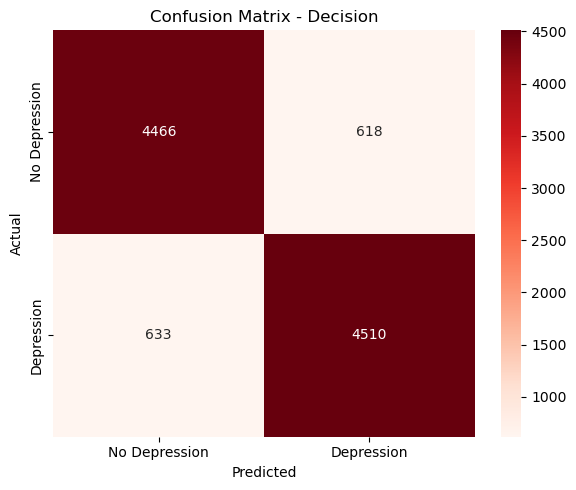

Accuracy: 0.8776767380463479
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5084
           1       0.88      0.88      0.88      5143

    accuracy                           0.88     10227
   macro avg       0.88      0.88      0.88     10227
weighted avg       0.88      0.88      0.88     10227



In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
clf = DecisionTreeClassifier()

start_time = time.time()
clf.fit(X_trainSplit, y_trainSplit)
end_time = time.time()
print(f"Time taken to train the Decision Tree Classifier: {end_time - start_time:.2f} seconds") #when probability is true (to collect data), it takes ~5 times longer to train

y_pred = clf.predict(X_testSplit)

cf_mx_clf = confusion_matrix(y_testSplit, y_pred)
# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_clf, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision')
plt.tight_layout()
plt.show()

accuracy_before = accuracy_score(y_testSplit, y_pred)
report = classification_report(y_testSplit, y_pred)
print("Accuracy:", accuracy_before)
print("Classification Report:\n", report)


##### Hyperparameter tuning

In [71]:
from sklearn.model_selection import GridSearchCV


parameter_grid = {
    'max_depth': [ 2, 4, 6, 8, 10, 12 ],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

cross_validation = StratifiedKFold(n_splits=10)


grid_search = GridSearchCV(estimator=clf,
                           param_grid=parameter_grid,
                           cv=cross_validation)


grid_search.fit(X_trainSplit, y_trainSplit)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

print(clf.get_params())
print(grid_search.best_params_)



Best score: 0.9154670368911659
Best parameters: {'max_depth': 8, 'max_features': 14}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
{'max_depth': 8, 'max_features': 14}


Os parâmetros que achamos mais relevantes de usar são a max_depth e as max_features.

- O parâmetro max_depth controla a profundidade que a árvore alcança, e, consequentemente, os nós a expandir.
- O parâmetro max_features controla o número de features a considerar na expansão de um nó.

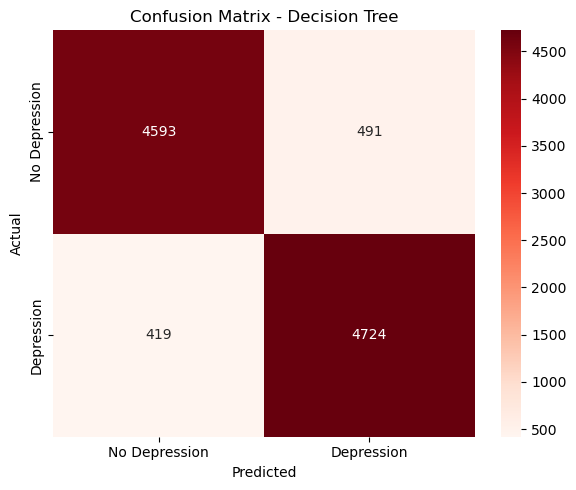

Accuracy: 0.9110198494182067
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5084
           1       0.91      0.92      0.91      5143

    accuracy                           0.91     10227
   macro avg       0.91      0.91      0.91     10227
weighted avg       0.91      0.91      0.91     10227



In [73]:
# Para usar o melhor modelo: (apos hyperparameter)
best_model = grid_search.best_estimator_
y_predBest = best_model.predict(X_testSplit)

cf_mx_clf = confusion_matrix(y_testSplit, y_predBest)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_clf, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

tree_accuracy_best = accuracy_score(y_testSplit, y_predBest)
report = classification_report(y_testSplit, y_predBest)
print("Accuracy:", tree_accuracy_best)
print("Classification Report:\n", report)

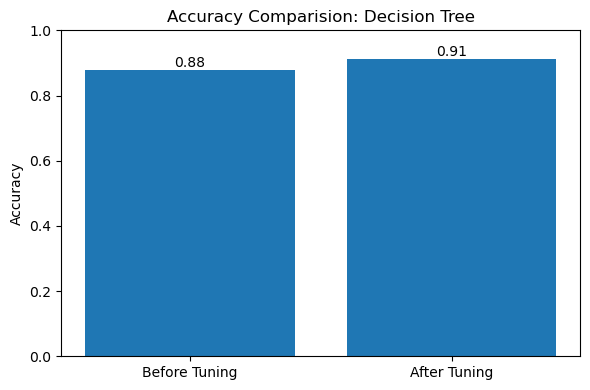

In [76]:
import matplotlib.pyplot as plt

labels = ['Before Tuning', 'After Tuning']
scores = [accuracy_before, tree_accuracy_best]

plt.figure(figsize=(6, 4))
plt.bar(labels, scores)
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision: Decision Tree')
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()


Através do gráfico é possível concluir que a melhoria na accuracy do modelo após realizar hyperparameter tunning foi significativa(0,88 para 0,97). 

Isto explica-se porque as árvores de decisão, na sua natureza, são propensas a _overfitting_ se não forem devidamente controladas.
Sem uma regulação explícita, normalmente concretizada através do _pruning_, uma Árvore de Decisão continua a expandir os nós até que cada nó folha contenha amostras de uma única classe ou até que não sejam possíveis mais expansões. Isto resulta numa árvore com muitas regras que pode classificar perfeitamente os dados de treino, mas com dificuldade a generalizar.

Para uma vista gráfica da influência destes parâmetros:

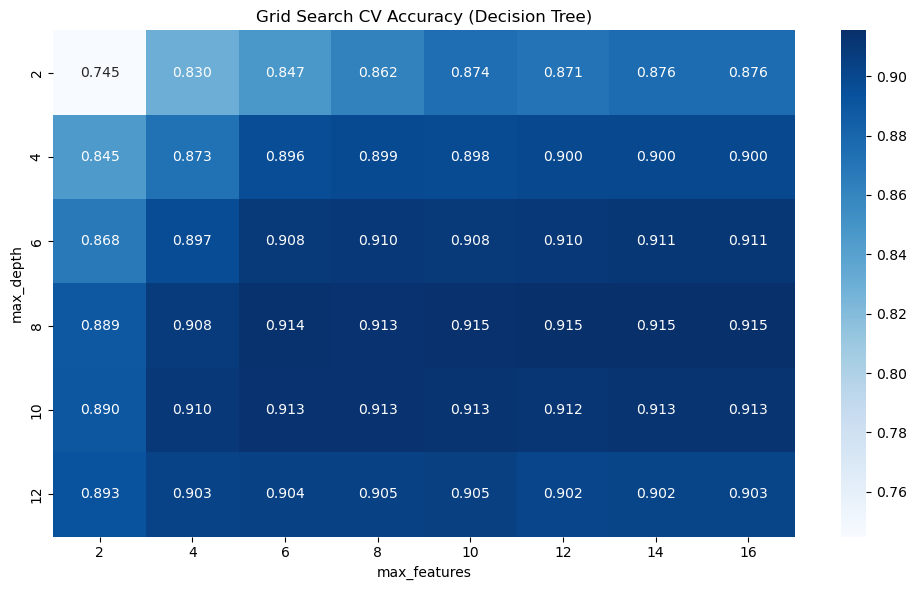

In [75]:
results = grid_search.cv_results_ 

depths = sorted(set(results['param_max_depth'].data))
features = sorted(set(results['param_max_features'].data))

scores = np.array(results['mean_test_score']).reshape(len(depths), len(features))

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap='Blues',
           xticklabels=features, yticklabels=depths)

plt.xlabel('max_features')
plt.ylabel('max_depth')
plt.title('Grid Search CV Accuracy (Decision Tree)')
plt.tight_layout()
plt.show()

##### Confusion Matrix and ROC Curve after Hyperparameter tuning

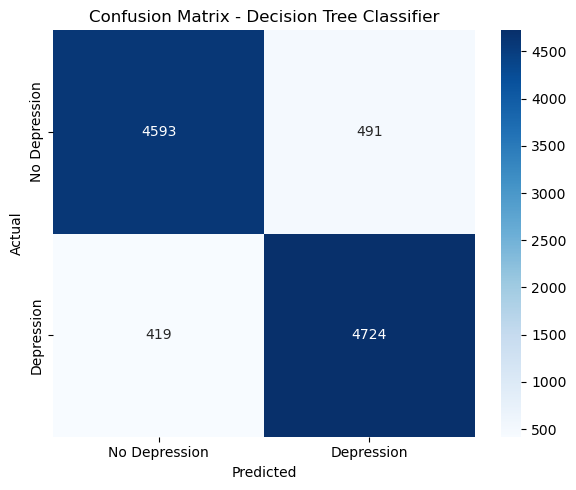

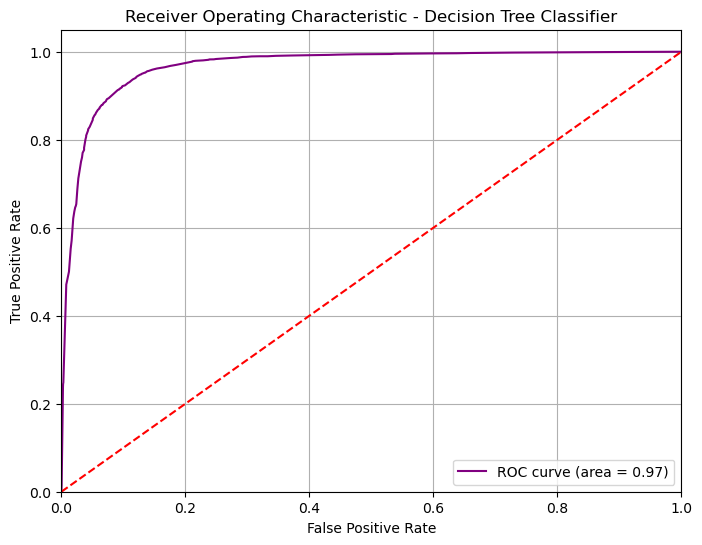

In [79]:
y_predBest = best_model.predict(X_testSplit)

cf_mx_clf = confusion_matrix(y_testSplit, y_predBest)

plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_clf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.tight_layout()
plt.show()

y_probBest = best_model.predict_proba(X_testSplit)[:, 1]
fpr, tpr, thresholds = roc_curve(y_testSplit, y_probBest)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

O Decision Tree Classifier não exige que os dados categóricos sejam convertidos em numéricos. No entanto, usamos as normalizações numéricas para uniformizar e simplificar a tarefa.

Relembremos o número de casos da amostra:

No depression: 5084

Depression: 5143

A matriz de confusão permite-nos concluir o seguinte:

- Verdadeiros Positivos (TP): 4724 – ~91,8%

- Verdadeiros Negativos (TN): 4793 - ~94,3%

- Falsos Positivos (FP): 491 – ~8,2%

- Falsos Negativos (FN): 419 – ~5,7%

O modelo está bom tanto para identificar corretamente quem tem depressão quanto quem não tem. A maioria dos casos foi classificada corretamente. Como esperávamos, o Decision Tree Classifier foi de todos o que produziu uma _accuracy_ inicial mais baixa, consequência da sua simplicidade. Por outro lado, o tempo de treino do modelo fica nos 0.2 segundos, afirmando-se como a alternativa menos dispendiosa em termos computacionais

A ROC curve mostra a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos. A Área sob a Curva (AUC) é 0.97, traduzindo a _accuracy_ do modelo.

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
#sem parâmetros
cv = StratifiedKFold(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_trainSplit, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#cv_scores = cross_val_score(clf, X_testSplit, y_testSplit, cv=cv)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title('Learning Curve - Decision Tree Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


#com parâmetros

clf_params = DecisionTreeClassifier(max_depth=9, max_features=10)
train_sizes, train_scores, test_scores = learning_curve(
    clf_params, X_trainSplit, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title('Learning Curve - Decision Tree Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


No caso sem parâmetros, a _training accuracy_ é praticamente fixa nos 1,00, para todas as dimensões do training dataset. Uma vez que isto quereria dizer que o modelo a funciona perfeitamente, nos dados em que foi treinado, pode indicar que estamos perante um _overfitting_ dos dados de treino. A _validation accuracy_  começa ligeiramente menor do que 0,87, e aumenta até estabilizar entre 0,87 e os 0,88, atingindo aí o seu máximo. A hipótese da ocorrência _overfitting_ é reforçada pela grande diferença entre as curvas, ou seja, o modelo "conhece demasiado bem" os dados de treino.

Pelo contrário, quando se limita a adaptação aos dados com os parâmetros obtidos através do parameter tuning, a validation accuracy sobe, mesmo a par da descida da training accuracy. Este comportamento de aproximação significa que o modelo está mais independente dos dados, pelo conseguimos aliviar o overfitting.

In [87]:
#previsão dos dados de teste
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=9, max_features=10)
clf.fit(X_trainSplit, y_trainSplit)

y_pred = clf.predict(test_data_clean)

print("Previsões:")
print(y_pred)


Previsões:
[0 0 0 ... 0 1 0]


NEURAL NETWORK (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mlp = MLPClassifier(max_iter=1000, random_state=42)

start_time = time.time()
mlp.fit(X_trainSplit, y_trainSplit)

end_time = time.time()
print(f"Time taken to train the MultiLayer Perceptron: {end_time - start_time:.2f} seconds") 

y_pred = mlp.predict(X_testSplit)

cf_mx_mlp = confusion_matrix(y_testSplit, y_pred)
plt.tight_layout()
plt.show()
neural_accuracy_before = accuracy_score(y_testSplit, y_pred)
report = classification_report(y_testSplit, y_pred)

print("Accuracy:", neural_accuracy_before)
print("Classification Report:\n", report)
print("Confusion matrix\n", cf_mx_mlp)

Time taken to train the MultiLayer Perceptron: 8.31 seconds


<Figure size 640x480 with 0 Axes>

Accuracy: 0.9249046641243767
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      5084
           1       0.92      0.93      0.93      5143

    accuracy                           0.92     10227
   macro avg       0.93      0.92      0.92     10227
weighted avg       0.93      0.92      0.92     10227

Confusion matrix
 [[4651  433]
 [ 335 4808]]


Para a nossa neural network, escolhemos usar um Multilayer Perceptron (MLP). Este é o tipo mais básico e fundamental de rede neuronal artificial (ANN). Chama-se "multilayer" consiste em várias camadas de neurónios.
A accuracy inicial deste modelo está nos 91,6%, o que é bastante aceitável. Não importa quantas corridas façamos, caimos sempre neste valor devido ao random_state, usado para conseguirmos comparar os modelos mais à frente. Se se variar o parâmetro random_state, teremos outros valores fixos. Esta, aleatoriamente, acaba por ser um dos melhores valores encontrados.

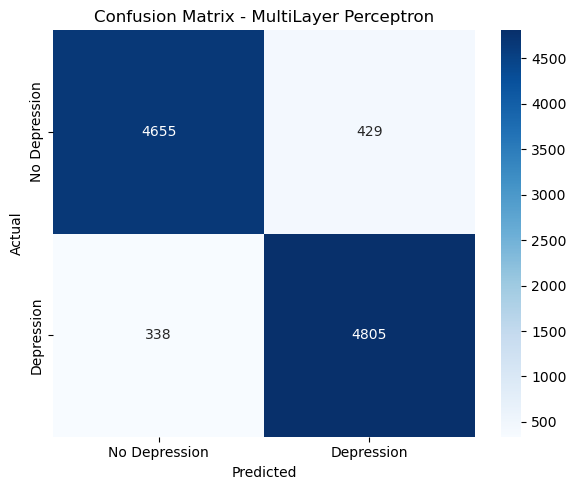

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_mlp, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MultiLayer Perceptron')
plt.tight_layout()
plt.show()

O Multi-layer Perceptron Classifier exige que os dados categóricos sejam convertidos em dados numéricos.
Relembremos o número de casos da amostra:

No depression: 5084

Depression: 5143

A matriz de confusão permite-nos concluir o seguinte:

- Verdadeiros Positivos (TP): 4805 – ~93,4%

- Verdadeiros Negativos (TN): 4655 - ~91,2%

- Falsos Positivos (FP): 491 – ~6,6%

- Falsos Negativos (FN): 419 – ~8,8%

#### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV


parameter_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh']
}

cross_validation = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


grid_search = GridSearchCV(estimator=mlp,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)


grid_search.fit(X_trainSplit, y_trainSplit)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

print(mlp.get_params())
print(grid_search.best_params_)




Best score: 0.9237538966151158
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
{'activation': 'relu', 'hidden_layer_sizes': (100,)}


Os parâmetros que achamos mais relevantes de usar são a hidden_layer_sizes e a activation.
- O parâmetro hidden_layer_sizes controla a arquitetura da rede neuronal, definindo o número de camadas ocultas e o número de neurónios em cada uma delas. Isso impacta diretamente a capacidade do modelo de aprender padrões complexos.
- O parâmetro activation controla a função de ativação usada nas camadas ocultas. Esta função introduz não-linearidade, necessária para que a rede possa modelar relações complexas nos dados.

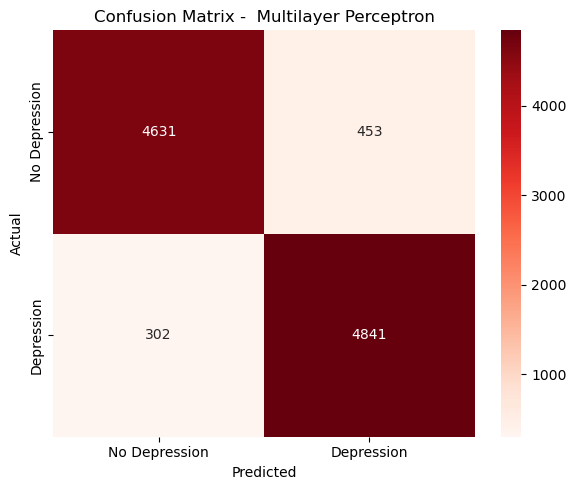

Mean Accuracy of 5 folds: 0.9237538966151158
Best Accuracy: 0.9261758091326879
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      5084
           1       0.91      0.94      0.93      5143

    accuracy                           0.93     10227
   macro avg       0.93      0.93      0.93     10227
weighted avg       0.93      0.93      0.93     10227



In [63]:
best_model = grid_search.best_estimator_
y_predBest = best_model.predict(X_testSplit)

cf_mx_mlp = confusion_matrix(y_testSplit, y_predBest)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_mlp, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix -  Multilayer Perceptron')
plt.tight_layout()
plt.show()

neural_accuracy_best = accuracy_score(y_testSplit, y_predBest)
report_mlp = classification_report(y_testSplit, y_predBest)
print("Mean Accuracy of 5 folds:", grid_search.best_score_)
print("Best Accuracy:", neural_accuracy_best)
print("Classification Report:\n", report_mlp)

A matriz de confusão permite-nos concluir o seguinte:

- Verdadeiros Positivos (TP): 4805 – ~94%

- Verdadeiros Negativos (TN): 4655 - ~91,5%

- Falsos Positivos (FP): 491 – ~6%

- Falsos Negativos (FN): 419 – ~8,5%

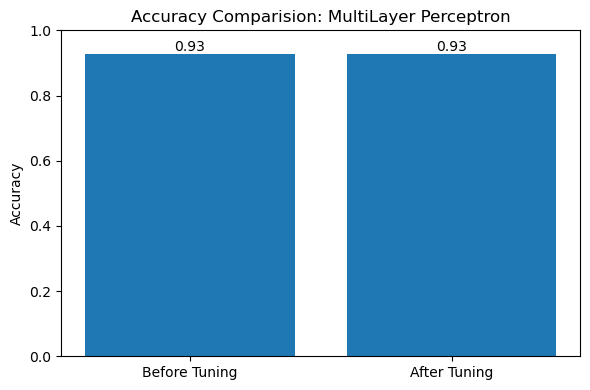

In [64]:
import matplotlib.pyplot as plt

labels = ['Before Tuning', 'After Tuning']
scores = [neural_accuracy_before, neural_accuracy_best]

plt.figure(figsize=(6, 4))
plt.bar(labels, scores)
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision: MultiLayer Perceptron')
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

A nossa accuracy não mudou muito entre o tuning de parâmetros e os parâmetros iniciais - isto porque para o nosso caso, os defaults do modelo (hidden_layer_sizes = (100,) e activation = 'relu') acabam por produzir um dos melhores resultados. Isto não invalida a nossa procura, pois precisávamos dela para chegar a esta conclusão.

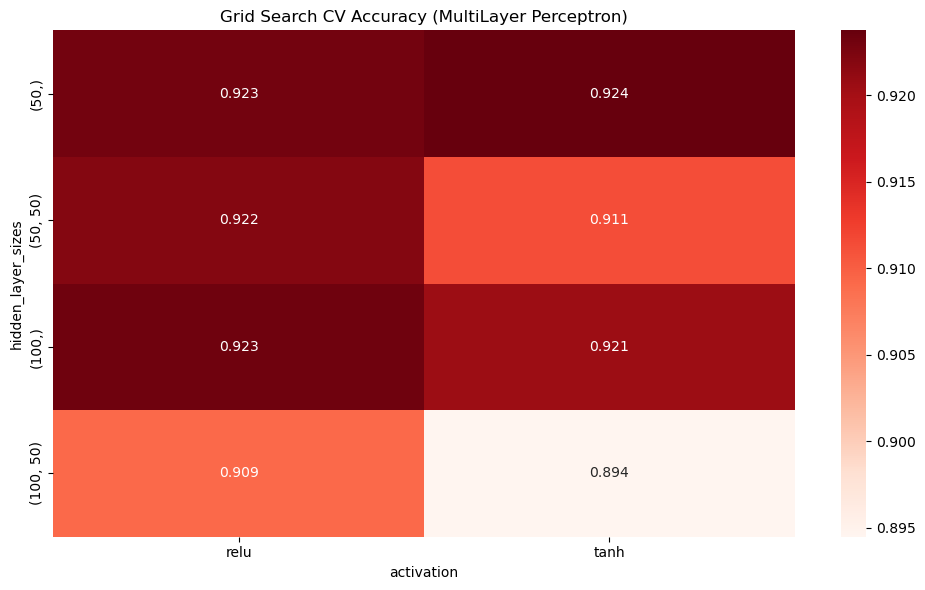

In [92]:
results = grid_search.cv_results_ 

depths = sorted(set(results['param_hidden_layer_sizes'].data))
features = sorted(set(results['param_activation'].data)) 

scores = np.array(results['mean_test_score']).reshape(len(depths), len(features)) 

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap='Reds',
           xticklabels=features, yticklabels=depths)

plt.xlabel('activation') 
plt.ylabel('hidden_layer_sizes') 
plt.title('Grid Search CV Accuracy (MultiLayer Perceptron)')
plt.tight_layout()
plt.show()

Duas combinações vencedoras: (50,0) com 'tanh' e (100,0) com 'relu' (vale a pena relaçar esta segunda, uma vez que são os defaults do modelo, correspondendo à nossa primeira corrida).

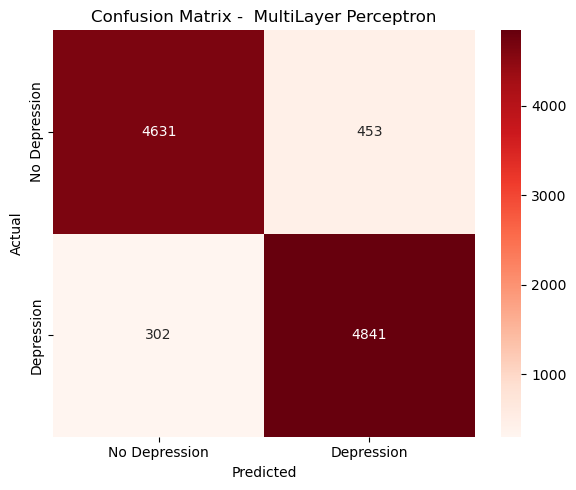

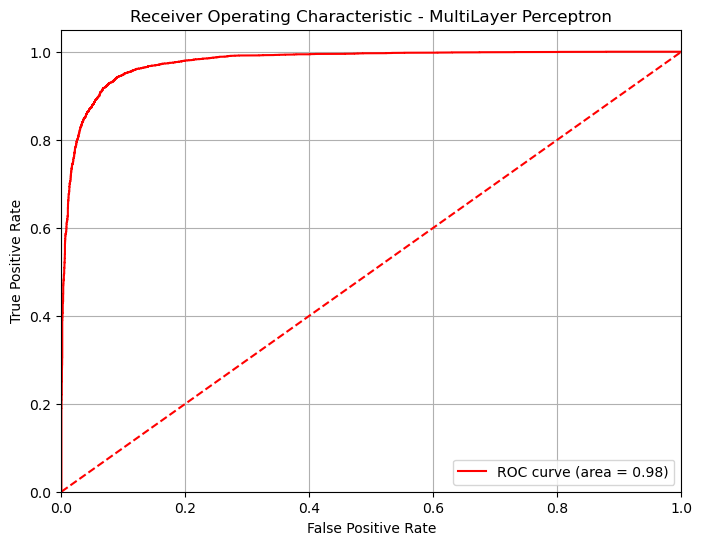

In [66]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf_mx_mlp, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix -  MultiLayer Perceptron')
plt.tight_layout()
plt.show()

y_probBest = best_model.predict_proba(X_testSplit)[:, 1]
fpr, tpr, thresholds = roc_curve(y_testSplit, y_probBest)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - MultiLayer Perceptron')
plt.legend(loc='lower right')
plt.grid()
plt.show()

A área debaixo da ROC curve é 0.98%.

--- Learning Curve 1: Default MLP (hidden_layer_sizes=(100,), activation='relu') ---
Validation Accuracy at approx. 10000 samples (actual 12271): 0.9221


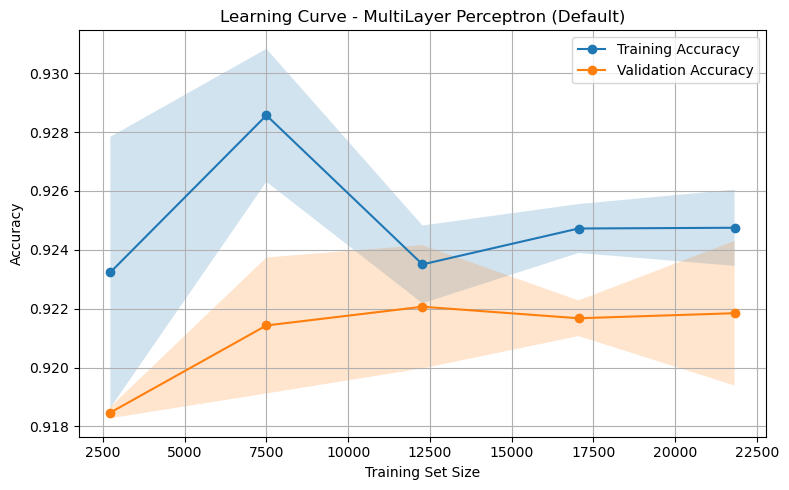


--- Learning Curve 2: MLP (activation='tanh', hidden_layer_sizes=(50,)) ---
Validation Accuracy at approx. 10000 samples (actual 12271): 0.9204


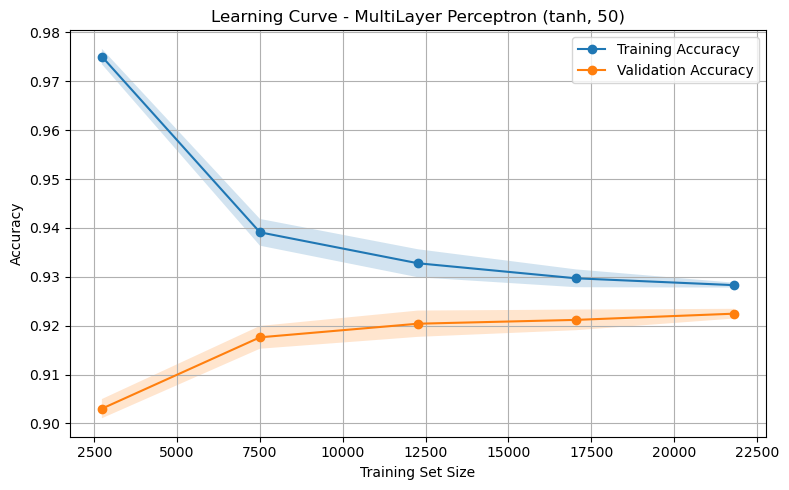


--- Learning Curve 3: MLP (activation='relu', hidden_layer_sizes=(100,)) ---
Validation Accuracy at approx. 10000 samples (actual 12271): 0.9221


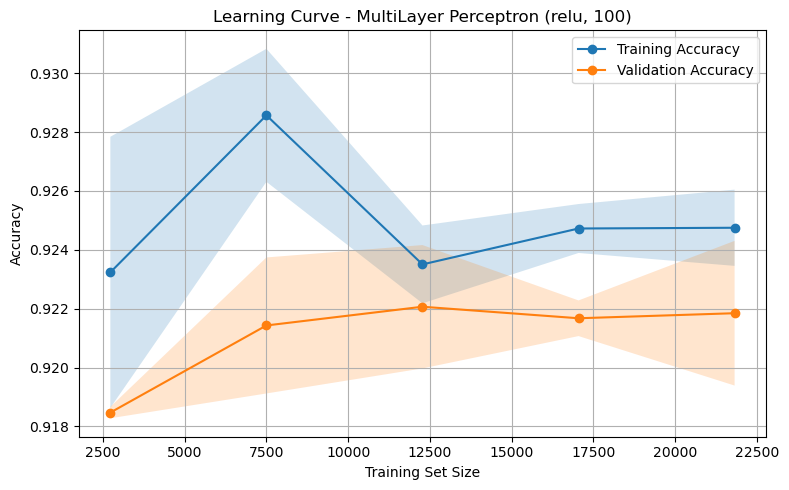

In [91]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Ensure seaborn is imported if used for heatmaps/plots


n_samples_train = X_trainSplit.shape[0]

TARGET_TRAIN_SIZE = 10000

def get_accuracy_at_target_size(train_sizes, test_mean, target_size):
    idx = np.abs(train_sizes - target_size).argmin()
    return test_mean[idx], train_sizes[idx]

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# --- Learning Curve 1: Default MLP (mlp) ---
mlp = MLPClassifier(max_iter=1000, random_state=42) # Ensure this is the base mlp

print("--- Learning Curve 1: Default MLP (hidden_layer_sizes=(100,), activation='relu') ---")
train_sizes_1, train_scores_1, test_scores_1 = learning_curve(
    mlp, X_trainSplit, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=-1
)

train_mean_1 = np.mean(train_scores_1, axis=1)
train_std_1 = np.std(train_scores_1, axis=1)
test_mean_1 = np.mean(test_scores_1, axis=1)
test_std_1 = np.std(test_scores_1, axis=1)

acc_at_10k_1, actual_size_1 = get_accuracy_at_target_size(train_sizes_1, test_mean_1, TARGET_TRAIN_SIZE)
print(f"Validation Accuracy at approx. {TARGET_TRAIN_SIZE} samples (actual {int(actual_size_1)}): {acc_at_10k_1:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_1, train_mean_1, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes_1, train_mean_1 - train_std_1, train_mean_1 + train_std_1, alpha=0.2)
plt.plot(train_sizes_1, test_mean_1, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes_1, test_mean_1 - test_std_1, test_mean_1 + test_std_1, alpha=0.2)
plt.title('Learning Curve - MultiLayer Perceptron (Default)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Learning Curve 2: mlp_params (activation='tanh', hidden_layer_sizes=(50,)) ---
mlp_params_2 = MLPClassifier(max_iter=1000, activation='tanh', hidden_layer_sizes=(50,), random_state=42)

print("\n--- Learning Curve 2: MLP (activation='tanh', hidden_layer_sizes=(50,)) ---")
train_sizes_2, train_scores_2, test_scores_2 = learning_curve(
    mlp_params_2, X_trainSplit, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=-1
)

train_mean_2 = np.mean(train_scores_2, axis=1)
train_std_2 = np.std(train_scores_2, axis=1)
test_mean_2 = np.mean(test_scores_2, axis=1)
test_std_2 = np.std(test_scores_2, axis=1)

acc_at_10k_2, actual_size_2 = get_accuracy_at_target_size(train_sizes_2, test_mean_2, TARGET_TRAIN_SIZE)
print(f"Validation Accuracy at approx. {TARGET_TRAIN_SIZE} samples (actual {int(actual_size_2)}): {acc_at_10k_2:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_2, train_mean_2, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes_2, train_mean_2 - train_std_2, train_mean_2 + train_std_2, alpha=0.2)
plt.plot(train_sizes_2, test_mean_2, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes_2, test_mean_2 - test_std_2, test_mean_2 + test_std_2, alpha=0.2)
plt.title('Learning Curve - MultiLayer Perceptron (tanh, 50)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Learning Curve 3: mlp_params (activation='relu', hidden_layer_sizes=(100,)) ---
mlp_params_3 = MLPClassifier(max_iter=1000, activation='relu', hidden_layer_sizes=(100,), random_state=42)

print("\n--- Learning Curve 3: MLP (activation='relu', hidden_layer_sizes=(100,)) ---")
train_sizes_3, train_scores_3, test_scores_3 = learning_curve(
    mlp_params_3, X_trainSplit, y_trainSplit, cv=cv,
    scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 5), n_jobs=-1
)

train_mean_3 = np.mean(train_scores_3, axis=1)
train_std_3 = np.std(train_scores_3, axis=1)
test_mean_3 = np.mean(test_scores_3, axis=1)
test_std_3 = np.std(test_scores_3, axis=1)

acc_at_10k_3, actual_size_3 = get_accuracy_at_target_size(train_sizes_3, test_mean_3, TARGET_TRAIN_SIZE)
print(f"Validation Accuracy at approx. {TARGET_TRAIN_SIZE} samples (actual {int(actual_size_3)}): {acc_at_10k_3:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_3, train_mean_3, 'o-', label='Training Accuracy')
plt.fill_between(train_sizes_3, train_mean_3 - train_std_3, train_mean_3 + train_std_3, alpha=0.2)
plt.plot(train_sizes_3, test_mean_3, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes_3, test_mean_3 - test_std_3, test_mean_3 + test_std_3, alpha=0.2)
plt.title('Learning Curve - MultiLayer Perceptron (relu, 100)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

No gráfico 2, o modelo está a memorizar excessivamente os dados de treino (alta accuracy de treino), mas não está a generalizar bem para os dados de validação (baixa accuracy de validação e grande gap).
A função tanh parece conduzir a um comportamento mais propenso a overfitting neste cenário em comparação com a relu ou o modelo default.
Apesar do max_iter=1000, o modelo parece encontrar uma solução que se ajusta aos dados de treino mas não generaliza bem. 
Os gráficos 3 e 1 mostram um comportamento mais equilibrado quando em comparação com o Gráfico 2. O modelo está a aprender bem os dados de treino e a generalizar razoavelmente bem para os dados de validação. O modelo não está nem underfitted nem overfitted severamente.

#### Prediction on real test data

In [86]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, activation='tanh', hidden_layer_sizes=(50,))

mlp.fit(X_trainSplit, y_trainSplit)

y_pred = mlp.predict(test_data_clean)

print("Previsões:")
print(y_pred)

Previsões:
[0 0 0 ... 0 1 0]


### Comparison between algorithms

In [ ]:
import matplotlib.pyplot as plt

labels = ['Decision Tree', 'KNN', 'Vector Machine', 'Neural Network']
scores = [tree_accuracy_best, knn_accuracy, vector_accuracy, neural_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
